In [26]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

## Lecture des datas

In [42]:
df = pd.read_csv("all_data.csv", sep=";")
print(f"{len(df)} tickers")

1247 tickers


## Exclusions

### Tabac / Armes controversées

In [43]:
df2 = df.loc[(df['CWEAP_TIE']!=1) & (df['TOB_PRODUCER']!=1),:]
print(f"{len(df2)} tickers")

1237 tickers


Elimination de 10 entreprises

### Controverses 0/1

In [44]:
columns_controverse = ["E_CONTROVERSY", "S_CONTROVERSY", 'G_CONTROVERSY']

In [45]:
# Controverse E
for col in columns_controverse:
    print(f"NB {col} : {len(df.loc[df[col]<2,:])}")

NB E_CONTROVERSY : 28
NB S_CONTROVERSY : 149
NB G_CONTROVERSY : 35


In [46]:
df3 = df2.loc[~df2[columns_controverse].lt(2).any(axis=1), :]
print(f"Elimination {len(df2)-len(df3)}")
print(f"Reste {len(df3)}")

Elimination 175
Reste 1062


### Note ESG < BB eet E > 3

In [32]:
print(f"NB : {len(df.loc[df["IVA_COMPANY_RATING"].isin(['B','CCC']),:])}")
df4 = df3.loc[~df3["IVA_COMPANY_RATING"].isin(['B','CCC']),:]
print(f"Elimination {len(df3)-len(df4)}")
print(f"Reste {len(df4)}")

NB : 17
Elimination 11
Reste 1051


In [52]:
print(f"NB : {len(df.loc[df["E_SCORE"]<=3,:])}")
df5 = df4.loc[df4["E_SCORE"]>3,:]
print(f"Elimination {len(df4)-len(df5)}")
print(f"Reste {len(df5)}")

NB : 64
Elimination 58
Reste 993


### Restrictions ODD

In [53]:
# odds = ["07","12","13"]
odds = [x for x in df.columns if x.startswith("SDG")]
for odd in odds:
    print(f"NB {odd} : {len(df.loc[df[odd]<=-2,:])}")

df6 = df5.loc[~df5[odds].le(-2).any(axis=1), :]
print(f"Elimination {len(df5)-len(df6)}")
print(f"Reste {len(df6)}")

df7 = df6.loc[~df6[odds].le(2).all(axis=1), :]
print(f"Elimination {len(df6)-len(df7)}")
print(f"Reste {len(df7)}")

NB SDG_01_NET_ALIGNMENT_SCORE : 28
NB SDG_02_NET_ALIGNMENT_SCORE : 7
NB SDG_03_NET_ALIGNMENT_SCORE : 48
NB SDG_04_NET_ALIGNMENT_SCORE : 16
NB SDG_05_NET_ALIGNMENT_SCORE : 1
NB SDG_06_NET_ALIGNMENT_SCORE : 14
NB SDG_07_NET_ALIGNMENT_SCORE : 83
NB SDG_08_NET_ALIGNMENT_SCORE : 6
NB SDG_09_NET_ALIGNMENT_SCORE : 37
NB SDG_10_NET_ALIGNMENT_SCORE : 9
NB SDG_11_NET_ALIGNMENT_SCORE : 51
NB SDG_12_NET_ALIGNMENT_SCORE : 106
NB SDG_13_NET_ALIGNMENT_SCORE : 83
NB SDG_14_NET_ALIGNMENT_SCORE : 64
NB SDG_15_NET_ALIGNMENT_SCORE : 66
NB SDG_16_NET_ALIGNMENT_SCORE : 28
NB SDG_17_NET_ALIGNMENT_SCORE : 70
Elimination 103
Reste 890
Elimination 157
Reste 733


In [11]:
odds_sociaux = ["01","02","03","04","05","06","08","10","16"]
odds_env = ["07","11","12","13","14","15"]

df7['DURABLE_SOCIAL'] = df7[[f'SDG_{col}_NET_ALIGNMENT_SCORE' for col in odds_sociaux]].max(axis=1)
df7['DURABLE_ENVIRONNEMENTAL'] = df7[[f'SDG_{col}_NET_ALIGNMENT_SCORE' for col in odds_env]].max(axis=1)

C:\Users\bapdu\AppData\Local\Temp\ipykernel_18696\2025602295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['DURABLE_SOCIAL'] = df7[[f'SDG_{col}_NET_ALIGNMENT_SCORE' for col in odds_sociaux]].max(axis=1)
C:\Users\bapdu\AppData\Local\Temp\ipykernel_18696\2025602295.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['DURABLE_ENVIRONNEMENTAL'] = df7[[f'SDG_{col}_NET_ALIGNMENT_SCORE' for col in odds_env]].max(axis=1)


In [60]:
len(durable_env)

733

In [61]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
df_fin = df7.copy()
df_fin['EST_EU_TAXONOMY_MAX_REV'] = df_fin['EST_EU_TAXONOMY_MAX_REV'].fillna(0)
df_fin['Annualized return 10Y'] = df_fin['Annualized return 10Y'].fillna(0)
# df6 = df5.loc[(df5['EST_EU_TAXONOMY_MAX_REV']>0) & (df5['ITR']>0),:] #Si Pas Taxo >0 trop de lignes => trop long a faire tourner

df_fin = df_fin.loc[(df_fin['ITR']>0),:]
# Nombre de tickers
n = len(df_fin)
print(n)
perf_moy = df_fin['Annualized return 20Y'].values
taxonomie = df_fin['EST_EU_TAXONOMY_MAX_REV'].values
itr = df_fin['ITR'].values
durable_social = df_fin['DURABLE_SOCIAL'].values
durable_env = df_fin['DURABLE_ENVIRONNEMENTAL'].values

secteurs_uniques = df_fin['gics_sector_name'].unique()  # Liste des secteurs uniques
m = len(secteurs_uniques)  # Nombre de secteurs

# Matrice binaire (1 si l'actif appartient au secteur, 0 sinon)
matrice_secteurs = np.array([[1 if df_fin.iloc[i]['gics_sector_name'] == secteur else 0 for secteur in secteurs_uniques] for i in range(n)])

# Fonction objectif (on minimise donc on prend -Perf_moy)
def objectif(w):
    return -np.dot(w, perf_moy)  # On minimise la valeur négative pour maximiser

# Contrainte : Taxonomie pondérée ≥ 10
def contrainte_taxonomie(w):
    return np.dot(w, taxonomie)-12

# Contrainte : ITR < 2
def contrainte_itr(w):
    return 1.95-np.dot(w, itr)

# Contrainte : Alignement environnemental pondéré ≥ 90%
def contrainte_alignement_social(w):
    filtres_env = (durable_env >= 2).astype(int)  # 1 si durable > 2, sinon 0

    # Calcul de la somme des poids des entreprises ayant un score durable > 2
    return np.dot(w, filtres_env) - 0.33  # Doit être ≥ 0

def contrainte_alignement_env(w):
    filtres_social = (durable_social >= 2).astype(int)  # 1 si durable > 2, sinon 0

    # Calcul de la somme des poids des entreprises ayant un score durable > 2
    return np.dot(w, filtres_social) - 0.33  # Doit être ≥ 0

def contrainte_secteur(w):
    return 0.30 - np.dot(matrice_secteurs.T, w)  # Doit être ≥ 0 pour chaque secteur

# Contrainte : Somme des poids = 1
def contrainte_somme(w):
    return np.sum(w) - 1


# Définition des contraintes sous forme de dictionnaires
contraintes = [
    {'type': 'eq', 'fun': contrainte_somme},  # Somme des poids = 1
    {'type': 'ineq', 'fun': contrainte_taxonomie},  # Taxonomie pondérée ≥ 10
    {'type': 'ineq', 'fun': contrainte_itr},  # ITR < 2
    {'type': 'ineq', 'fun': contrainte_alignement_social},  # Investissement durable Social ≥ 30%
    {'type': 'ineq', 'fun': contrainte_alignement_env}  # Investissement durable env≥ 30%
]

contraintes_secteurs = [{'type': 'ineq', 'fun': lambda w, j=j: contrainte_secteur(w)[j]} for j in range(m)]

contraintes = contraintes + contraintes_secteurs

# Bornes (chaque poids doit être positif et max 0.1)
bornes = [(0, 0.075) for _ in range(n)]

# Initialisation des poids (égalité répartie)
w0 = np.ones(n) / n

# Résolution avec SLSQP
resultat = minimize(objectif, w0, method='SLSQP', bounds=bornes, constraints=contraintes)

# Vérification des résultats
if resultat.success:
    w_opt = resultat.x
    df_fin['Poids'] = w_opt
else:
    print("L'optimisation a échoué :", resultat.message)

731


In [62]:
print(f"Return PTF : {(df_fin['Poids']*df_fin['Annualized return 20Y']).sum()}")
print(f"TAXO : {(df_fin['Poids']*df_fin['EST_EU_TAXONOMY_MAX_REV']).sum()}") 
print(f"ITR : {(df_fin['Poids']*df_fin['ITR']).sum()}") 
print(f"Poids : {(df_fin['Poids']).sum()}") 
filtres_durables_social = (df_fin['DURABLE_SOCIAL'] >= 2).astype(int)  # 1 si durable > 2, sinon 0.astype(int)  # 1 si durable > 2, sinon 0
print(f"Investissement durable Social: {(filtres_durables_social*df_fin['Poids']).sum()}") 

filtres_durables_env = (df_fin['DURABLE_ENVIRONNEMENTAL'] >= 2).astype(int)  # 1 si durable > 2, sinon 0.astype(int)  # 1 si durable > 2, sinon 0
print(f"Investissement durable Environnemental: {(filtres_durables_env*df_fin['Poids']).sum()}") 

col_scores = ['E_SCORE', 'S_SCORE', 'G_SCORE']
for col in col_scores:
    print(f"{col} : {(df_fin[col]*df_fin['Poids']).sum()}") 

col_inten = ['INTENSITY_SCOPE_1', 'INTENSITY_SCOPE_2', 'INTENSITY_SCOPE_3']
for col in col_inten:
    print(f"{col} : {(df_fin[col]*df_fin['Poids']).sum()}") 

    
col_foot = ['FOOTPRINT_SCOPE_1', 'FOOTPRINT_SCOPE_2', 'FOOTPRINT_SCOPE_3']
for col in col_foot:
    print(f"{col} : {(df_fin[col]*df_fin['Poids']).sum()}")

for col in odds:
    print(f"{col} : {(df_fin[col]*df_fin['Poids']).sum()}")

Return PTF : 0.3194471883554733
TAXO : 12.000000000072163
ITR : 1.9499999999586293
Poids : 1.0000000000002123
Investissement durable Social: 0.8077348320602452
Investissement durable Environnemental: 0.6144613488961099
E_SCORE : 7.066433753977812
S_SCORE : 5.584046966455148
G_SCORE : 6.156075977816603
INTENSITY_SCOPE_1 : 10.505252143782528
INTENSITY_SCOPE_2 : 4.277409488179751
INTENSITY_SCOPE_3 : 247.60317477990927
FOOTPRINT_SCOPE_1 : 7.784276449471127
FOOTPRINT_SCOPE_2 : 2.729340743749261
FOOTPRINT_SCOPE_3 : 169.08723210923873
SDG_01_NET_ALIGNMENT_SCORE : 0.6927693255524314
SDG_02_NET_ALIGNMENT_SCORE : 0.1609809047797907
SDG_03_NET_ALIGNMENT_SCORE : 0.3375000000000498
SDG_04_NET_ALIGNMENT_SCORE : 0.31250000000004485
SDG_05_NET_ALIGNMENT_SCORE : 2.249157529852344
SDG_06_NET_ALIGNMENT_SCORE : 0.7071134887500219
SDG_07_NET_ALIGNMENT_SCORE : 1.2489916847762803
SDG_08_NET_ALIGNMENT_SCORE : 1.599440560626597
SDG_09_NET_ALIGNMENT_SCORE : 0.8153591008064333
SDG_10_NET_ALIGNMENT_SCORE : 1.8563

In [64]:
df_fin[df_fin['Poids']>0.001]

,ticker,name,isin,country,currency,gics_sector_name,industry_group,region_en,Weight in MSCI World,Annualized return 20Y,...,FOOTPRINT_SCOPE_2,FOOTPRINT_SCOPE_3,INTENSITY_SCOPE_1,INTENSITY_SCOPE_2,INTENSITY_SCOPE_3,EV,SALES,DURABLE_SOCIAL,DURABLE_ENVIRONNEMENTAL,Poids
1,NVDA US Equity,NVIDIA Corp,US67066G1040,UNITED STATES,USD,Information Technology,Semiconductors,North America,0.046132,0.396705,...,0.224788,34.721009,0.131528,1.627755,251.425343,3.359642e+06,109406.527100,2.5,6.5,0.075000
7,AVGO US Equity,Broadcom Inc,US11135F1012,UNITED STATES,USD,Information Technology,Semiconductors,North America,0.015473,0.317303,...,0.942548,69.793000,1.179637,3.735015,276.567279,8.371146e+05,49815.326600,2.5,1.5,0.075000
14,MA US Equity,Mastercard Inc,US57636Q1040,UNITED STATES,USD,Financials,Diversified Finan Serv,North America,0.006298,0.289978,...,0.459141,24.730839,0.135197,1.843861,99.316304,4.479303e+05,26302.422900,2.5,2.0,0.075000
19,NFLX US Equity,Netflix Inc,US64110L1061,UNITED STATES,USD,Communication Services,Internet,North America,0.005515,0.376162,...,0.415922,115.939906,0.711690,0.836228,233.102162,3.089634e+05,36237.703140,2.5,1.0,0.075000
22,CRM US Equity,Salesforce Inc,US79466L3024,UNITED STATES,USD,Information Technology,Software,North America,0.004466,0.256363,...,4.381089,59.867483,0.111356,7.794915,106.517341,2.710248e+05,35920.855100,2.5,3.5,0.075000
151,MELI US Equity,MercadoLibre Inc,US58733R1023,URUGUAY,USD,Consumer Discretionary,Internet,Latin America,0.001209,0.269122,...,0.752707,276.198071,25.613938,0.973390,357.175439,1.005309e+05,18331.816100,2.5,0.0,0.010539
155,CMG US Equity,Chipotle Mexican Grill Inc,US1696561059,UNITED STATES,USD,Consumer Discretionary,Retail,North America,0.001189,0.284092,...,8.242878,109.326461,13.711046,14.566726,193.200545,7.951385e+04,10610.277240,2.5,2.0,0.075000
173,REGN US Equity,Regeneron Pharmaceuticals Inc,US75886F1075,UNITED STATES,USD,Health Care,Biotechnology,North America,0.001099,0.254785,...,2.026112,96.964499,5.203772,3.970119,189.999664,1.111384e+05,13374.913890,5.0,2.0,0.075000
228,CSU CN Equity,Constellation Software Inc,CA21037X1006,CANADA,CAD,Information Technology,Software,North America,0.000895,0.324291,...,3.295466,47.809818,0.494831,5.729231,83.118282,6.524871e+04,8850.330312,1.5,1.0,0.075000
448,DECK US Equity,Deckers Outdoor Corp,US2435371073,UNITED STATES,USD,Consumer Discretionary,Apparel,North America,0.000447,0.255144,...,0.053488,511.354258,0.102178,0.063306,605.218692,2.259569e+04,4501.964276,2.5,2.0,0.075000


In [12]:
print(f"Return PTF : {(df['Weight in MSCI World']*df['Annualized return 20Y']).sum()}")
print(f"TAXO : {(df['Weight in MSCI World']*df['EST_EU_TAXONOMY_MAX_REV']).sum()}") 
print(f"ITR : {(df['Weight in MSCI World']*df['ITR']).sum()}") 
print(f"Poids : {(df['Weight in MSCI World']).sum()}") 
df['INVEST_DURABLE'] = df[['SDG_07_NET_ALIGNMENT_SCORE', 'SDG_12_NET_ALIGNMENT_SCORE', 'SDG_13_NET_ALIGNMENT_SCORE']].max(axis=1)
filtres_durables = (df['INVEST_DURABLE'] >= 2).astype(int)  # 1 si durable > 2, sinon 0.astype(int)  # 1 si durable > 2, sinon 0
print(f"Investissement durable : {(filtres_durables*df['Weight in MSCI World']).sum()}") 

col_scores = ['E_SCORE', 'S_SCORE', 'G_SCORE']
for col in col_scores:
    print(f"{col} : {(df[col]*df['Weight in MSCI World']).sum()}") 

col_inten = ['INTENSITY_SCOPE_1', 'INTENSITY_SCOPE_2', 'INTENSITY_SCOPE_3']
for col in col_inten:
    print(f"{col} : {(df[col]*df['Weight in MSCI World']).sum()}") 

col_foot = ['FOOTPRINT_SCOPE_1', 'FOOTPRINT_SCOPE_2', 'FOOTPRINT_SCOPE_3']
for col in col_foot:
    print(f"{col} : {(df[col]*df['Weight in MSCI World']).sum()}")

for col in odds:
    print(f"{col} : {(df[col]*df['Weight in MSCI World']).sum()}")

Return PTF : 0.1589968660964774
TAXO : 8.88141198983
ITR : 2.3882738824
Poids : 0.999999286
Investissement durable : 0.556473561
E_SCORE : 6.702299149800001
S_SCORE : 5.1125413661
G_SCORE : 5.6482565943
INTENSITY_SCOPE_1 : 75.69229832018408
INTENSITY_SCOPE_2 : 19.946423978449946
INTENSITY_SCOPE_3 : 756.2246020384931
FOOTPRINT_SCOPE_1 : 118.00648809367438
FOOTPRINT_SCOPE_2 : 27.010985263301677
FOOTPRINT_SCOPE_3 : 1373.604056364562
SDG_01_NET_ALIGNMENT_SCORE : 0.0775825055
SDG_02_NET_ALIGNMENT_SCORE : 0.019335309000000002
SDG_03_NET_ALIGNMENT_SCORE : -0.111505415
SDG_04_NET_ALIGNMENT_SCORE : -0.022077644
SDG_05_NET_ALIGNMENT_SCORE : 1.9017966155000001
SDG_06_NET_ALIGNMENT_SCORE : 0.9266744179999999
SDG_07_NET_ALIGNMENT_SCORE : 0.6206072210000001
SDG_08_NET_ALIGNMENT_SCORE : 1.0800233255
SDG_09_NET_ALIGNMENT_SCORE : 0.100041403
SDG_10_NET_ALIGNMENT_SCORE : 1.0660665655
SDG_11_NET_ALIGNMENT_SCORE : -0.03663600200000001
SDG_12_NET_ALIGNMENT_SCORE : 1.034473784
SDG_13_NET_ALIGNMENT_SCORE : 0

In [65]:
# Repartition sectorielle
round((df_fin.groupby('gics_sector_name')['Poids'].sum())*100,2)

gics_sector_name
Communication Services    22.50
Consumer Discretionary    16.05
Consumer Staples           0.00
Energy                     0.00
Financials                 7.50
Health Care                7.50
Industrials                4.23
Information Technology    30.00
Materials                  4.72
Real Estate                7.50
Utilities                  0.00
Name: Poids, dtype: float64

In [66]:
# Sous secteur
df_sect = df_fin.groupby('industry_group')['Poids'].sum()
round(df_sect[df_sect>0.01]*100,2)

industry_group
Apparel                    7.50
Biotechnology              7.50
Commercial Services        4.23
Diversified Finan Serv     7.50
Forest Products&Paper      4.72
Internet                   8.55
Media                      7.50
Real Estate               15.00
Retail                     7.50
Semiconductors            15.00
Software                  15.00
Name: Poids, dtype: float64

In [67]:
# Repartition geo
df_geo = df_fin.groupby('country')['Poids'].sum()
round(df_geo[df_geo>0.01]*100,2)

country
AUSTRALIA         7.50
BRITAIN           4.23
CANADA            7.50
FRANCE            7.50
SWEDEN           12.22
UNITED STATES    60.00
URUGUAY           1.05
Name: Poids, dtype: float64

In [69]:
# Repartition geo
df_esg = df_fin.groupby('IVA_COMPANY_RATING')['Poids'].sum()
round(df_esg[df_esg>0.01]*100,2)

IVA_COMPANY_RATING
A      16.05
AA     34.23
AAA    19.72
BB      7.50
BBB    22.50
Name: Poids, dtype: float64

In [70]:
df_fin[df_fin['Poids']>0.001]['EST_EU_TAXONOMY_MAX_REV']

1       78.01
7        0.45
14       0.00
19       0.00
22      18.97
151      0.00
155      0.00
173      0.00
228      0.00
448      0.00
496      1.77
1070    69.48
1076     0.00
1203    17.85
1236     0.00
Name: EST_EU_TAXONOMY_MAX_REV, dtype: float64

C:\Users\bapdu\AppData\Local\Temp\ipykernel_18696\3671985498.py:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thibc\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


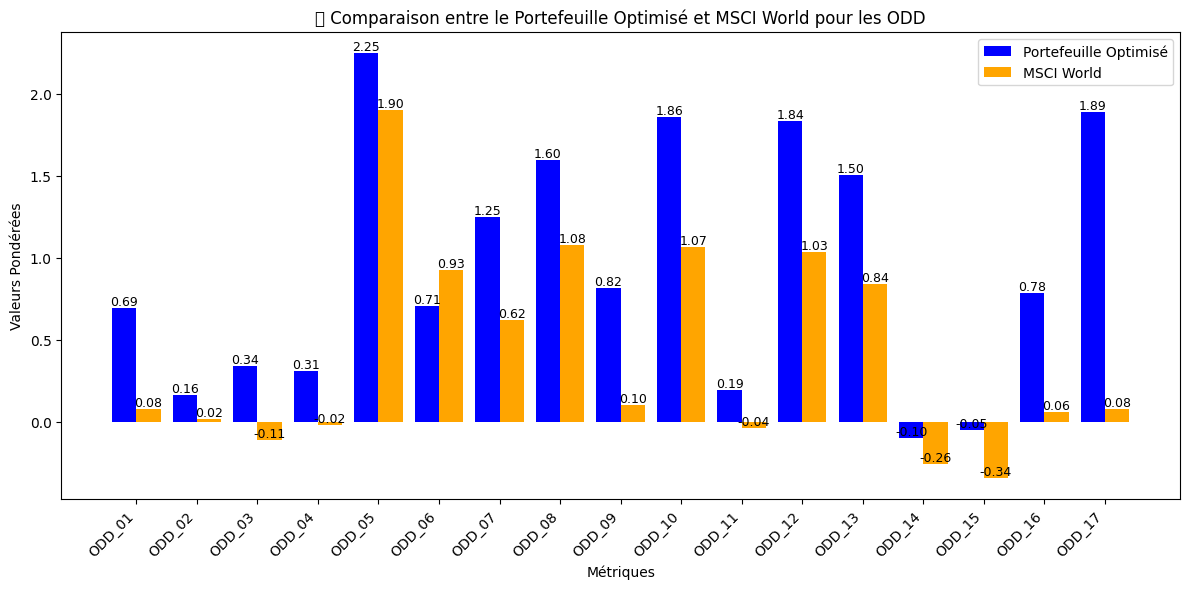

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 📌 Calcul des valeurs pour df6 (portefeuille optimisé)
df_fin_values = [
    (df_fin['Poids'] * df_fin[metric]).sum() if metric in df_fin.columns else None for metric in odds
]

# 📌 Calcul des valeurs pour df (MSCI World)
df_values = [
    (df['Weight in MSCI World'] * df[metric]).sum() if metric in df.columns else None for metric in odds
]

# 📌 Création du graphique
x = np.arange(len(odds))  # Indices des barres
width = 0.4  # Largeur des barres

fig, ax = plt.subplots(figsize=(12, 6))

# 🔹 Barres pour le portefeuille optimisé (df6)
bars1 = ax.bar(x - width/2, df_fin_values, width, label="Portefeuille Optimisé", color='blue')

# 🔹 Barres pour MSCI World (df)
bars2 = ax.bar(x + width/2, df_values, width, label="MSCI World", color='orange')

# 📌 Personnalisation du graphique
ax.set_xlabel("Métriques")
ax.set_ylabel("Valeurs Pondérées")
ax.set_title("📊 Comparaison entre le Portefeuille Optimisé et MSCI World pour les ODD")
ax.set_xticks(x)
ax.set_xticklabels(["ODD_"+x.split("_")[1] for x in odds], rotation=45, ha="right")
ax.legend()

# 📌 Ajouter les valeurs sur les barres
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha="center", va="bottom", fontsize=9)

# 📌 Affichage
plt.tight_layout()
plt.show()


In [27]:
import plotly.graph_objects as go
import numpy as np

# 📌 Calcul des valeurs pour df6 (portefeuille optimisé)
df6_values = [
    (df6['Poids'] * df6[metric]).sum() if metric in df6.columns else None for metric in odds
]

# 📌 Calcul des valeurs pour df (MSCI World)
df_values = [
    (df['Weight in MSCI World'] * df[metric]).sum() if metric in df.columns else None for metric in odds
]

# 📌 Création du graphique
x = np.arange(len(odds))  # Indices des barres

fig = go.Figure()

# 🔹 Barres pour le portefeuille optimisé (df6)
fig.add_trace(go.Bar(
    x=["ODD_" + x.split("_")[1] for x in odds],
    y=df6_values,
    name="Fonds article 9",
    marker_color='blue'
))

# 🔹 Barres pour MSCI World (df)
fig.add_trace(go.Bar(
    x=["ODD_" + x.split("_")[1] for x in odds],
    y=df_values,
    name="MSCI World",
    marker_color='orange'
))

# 📌 Personnalisation du graphique
fig.update_layout(
    title="Comparaison entre notre fonds article 9 et et MSCI World pour les ODD",
    xaxis_title="ODD",
    yaxis_title="Score moyen",
    barmode='group',
    template='plotly_white',  # Thème professionnel
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="black"
    ),
    legend=dict(
        title="Légende",
        x=0.02, y=0.98,
        bgcolor='rgba(255,255,255,0.7)',
        bordercolor='black',
        borderwidth=1
    )
)

# 📌 Affichage
fig.show()

In [33]:
scores = ['SCOPE_1', 'SCOPE_2', 'SCOPE_3', 'FOOTPRINT_SCOPE_1', 'FOOTPRINT_SCOPE_2', 'FOOTPRINT_SCOPE_3']

# 📌 Calcul des valeurs pour df6 (portefeuille optimisé)
df6_values = [
    (df6['Poids'] * df6[metric]).sum() if metric in df6.columns else None for metric in scores
]

# 📌 Calcul des valeurs pour df (MSCI World)
df_values = [
    (df['Weight in MSCI World'] * df[metric]).sum() if metric in df.columns else None for metric in scores
]

# 📌 Création du graphique
x = np.arange(len(scores))  # Indices des barres

fig = go.Figure()

# 🔹 Barres pour le portefeuille optimisé (df6)
fig.add_trace(go.Bar(
    x=[x for x in scores],
    y=df6_values,
    name="Fonds article 9",
    marker_color='blue'
))

# 🔹 Barres pour MSCI World (df)
fig.add_trace(go.Bar(
    x=[x for x in scores],
    y=df_values,
    name="MSCI World",
    marker_color='orange'
))

# 📌 Personnalisation du graphique
fig.update_layout(
    title="Comparaison entre notre fonds article 9 et et MSCI World pour les scores E,S & G et les scores de controverses",
    xaxis_title="Pilier",
    yaxis_title="Score moyen",
    barmode='group',
    template='plotly_white',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="black"
    ),
    legend=dict(
        title="Légende",
        x=0.02, y=0.98,
        bgcolor='rgba(255,255,255,0.7)',
        bordercolor='black',
        borderwidth=1
    )
)

# 📌 Affichage
fig.show()

In [ ]:
scores = ['SCOPE_1', 'SCOPE_2', 'SCOPE_3', 'FOOTPRINT_SCOPE_1', 'FOOTPRINT_SCOPE_2', 'FOOTPRINT_SCOPE_3']

# 📌 Calcul des valeurs pour df6 (portefeuille optimisé)
df6_values = [
    (df6['Poids'] * df6[metric]).sum() if metric in df6.columns else None for metric in scores
]

# 📌 Calcul des valeurs pour df (MSCI World)
df_values = [
    (df['Weight in MSCI World'] * df[metric]).sum() if metric in df.columns else None for metric in scores
]

# 📌 Création du graphique
x = np.arange(len(scores))  # Indices des barres

fig = go.Figure()

# 🔹 Barres pour le portefeuille optimisé (df6)
fig.add_trace(go.Bar(
    x=[x for x in scores],
    y=df6_values,
    name="Fonds article 9",
    marker_color='blue'
))

# 🔹 Barres pour MSCI World (df)
fig.add_trace(go.Bar(
    x=[x for x in scores],
    y=df_values,
    name="MSCI World",
    marker_color='orange'
))

# 📌 Personnalisation du graphique
fig.update_layout(
    title="Comparaison entre notre fonds article 9 et et MSCI World pour les scores Scopes 1 à 3",
    xaxis_title="Pilier",
    yaxis_title="Score moyen",
    barmode='group',
    template='plotly_white',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="black"
    ),
    legend=dict(
        title="Légende",
        x=0.02, y=0.98,
        bgcolor='rgba(255,255,255,0.7)',
        bordercolor='black',
        borderwidth=1
    )
)

# 📌 Affichage
fig.show()